In [11]:
# install and import above modules first
import os
import cv2
import matplotlib.pyplot as pl
import pandas as pd
from PIL import Image
import numpy as np

In [12]:
path = cv2.data.haarcascades
face_detector = cv2.CascadeClassifier(os.path.join(path, "haarcascade_frontalface_default.xml"))
eye_detector = cv2.CascadeClassifier(os.path.join(path, "haarcascade_eye.xml"))

# Input paths
test_set = ["data/one.jpg", "data/two.png"]

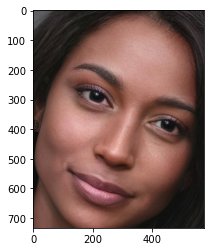

[[330 200 153 153]
 [ 76  89 175 175]]


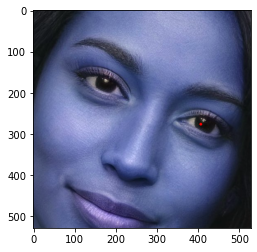

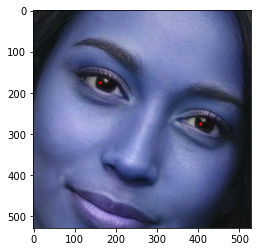

Rotate ACW
Rotation angle:  22.368275027390183


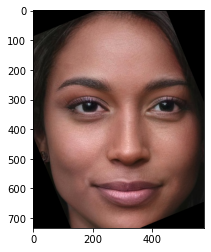

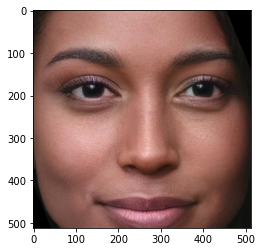

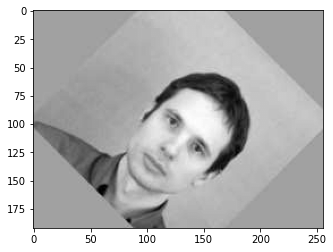

[[ 6 18 23 23]
 [27 39 25 25]]


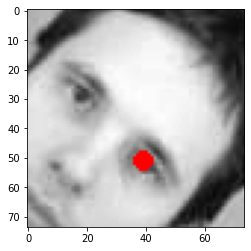

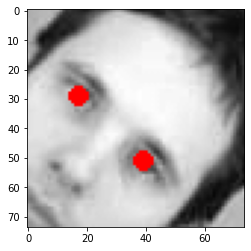

Rotate ACW
Rotation angle:  45.0


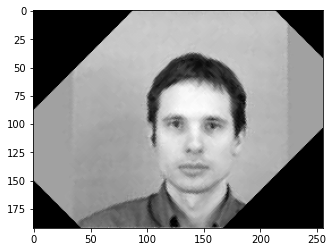

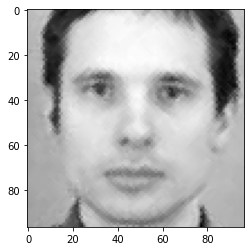

In [13]:
# Detect face using cv2 
def face_detection(img):
	faces = face_detector.detectMultiScale(img, 1.1, 4)
	if (len(faces) > 0):
		X, Y, W, H = faces[0]
		img = img[int(Y):int(Y+H), int(X):int(X+W)]
		return img, cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
	else:
		exit(0)

def euclidean_distance(a, b):
	# sqrt((x2 - x1)^2 + (y2 - y1)^2)
	return np.sqrt(((b[0] - a[0]) ** 2) + ((b[1] - a[1]) ** 2))

# Find eyes
def Face_Alignment(img_path):
	pl.imshow(cv2.imread(img_path)[:, :, ::-1])
	pl.show()
	img_raw = cv2.imread(img_path).copy()
	img, gray_img = face_detection(cv2.imread(img_path))
	eyes = eye_detector.detectMultiScale(gray_img)

	# for multiple people in an image find the largest
	# pair of eyes
	if len(eyes) >= 2:
		eye = eyes[:, 2]
		container1 = []
		for i in range(0, len(eye)):
			container = (eye[i], i)
			container1.append(container)
		df = pd.DataFrame(container1, columns=[
						"length", "idx"]).sort_values(by=['length'])
		eyes = eyes[df.idx.values[0:2]]

		# choose between left or right eye
		print(eyes)
		eye_1 = eyes[0]
		eye_2 = eyes[1]
		if eye_1[0] > eye_2[0]:
			left_eye = eye_2
			right_eye = eye_1
		else:
			left_eye = eye_1
			right_eye = eye_2

		# center of eyes
		# center of right eye
		right_eye_center = (right_eye[0] + right_eye[2] //2 , right_eye[1] + right_eye[3] // 2)
		right_eye_x = right_eye_center[0]
		right_eye_y = right_eye_center[1]
		# draw a circle on the center of right eye
		pl.imshow(cv2.circle(img, right_eye_center, 2, (255, 0, 0), 2))
		pl.show()


		# center of left eye
		left_eye_center = (left_eye[0] + left_eye[2] // 2, left_eye[1] + left_eye[3] // 2)
		left_eye_x = left_eye_center[0]
		left_eye_y = left_eye_center[1]
		pl.imshow(cv2.circle(img, left_eye_center, 2, (255, 0, 0), 2))
		pl.show()

		# finding rotation direction
		if left_eye_y > right_eye_y:
			print("Rotate CW")
			point_3rd = (right_eye_x, left_eye_y)
			direction = -1 # rotate CW
		else:
			print("Rotate ACW")
			point_3rd = (left_eye_x, right_eye_y)
			direction = 1 # rotate ACW

		cv2.circle(img, point_3rd, 2, (255, 0, 0), 2)
		a = euclidean_distance(left_eye_center, point_3rd)
		b = euclidean_distance(right_eye_center, point_3rd)
		c = euclidean_distance(right_eye_center, left_eye_center)
		cos_a = (b ** 2 + c ** 2 - a ** 2) / (2 * b * c)
		angle = np.degrees(np.arccos(cos_a))
		#angle = -direction * (90 - angle)
		print("Rotation angle: ", angle)

		# rotate image
		new_img = Image.fromarray(img_raw)
		new_img = np.array(new_img.rotate(direction * angle))

	return new_img


# Name of the image for face alignment if on
# the other folder kindly paste the name of
# the image with path included
for i in test_set:
	alignedFace = Face_Alignment(i)
	pl.imshow(alignedFace[:, :, ::-1])
	pl.show()
	img, gray_img = face_detection(alignedFace)
	pl.imshow(img[:, :, ::-1])
	pl.show()